In [65]:
!pip install opendatasets
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.6 MB/s eta 0:00:00


## Импорты и инициализация библиотек

In [42]:
import os
import random
from collections import Counter
from typing import Sequence

import matplotlib.pyplot as plt
import nltk
import numpy as np
import opendatasets as od
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer, sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchmetrics import F1Score
from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

nltk.download("punkt")
nltk.download("stopwords")
tqdm_notebook.pandas()

[nltk_data] Downloading package punkt to
[nltk_data]     /home/starminalush/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/starminalush/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Фиксируем random seed для воспроизводимости

In [43]:
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

In [44]:
tokenizer = WordPunctTokenizer()

In [45]:
MAX_SENTENSE_LEN = 300
MIN_FREQUENCY_OF_OCCURRENCE = 20

## Скачиваем датасет, делаем предобработку

In [5]:
od.download("http://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  bluberryfox


Your Kaggle Key:

  ········


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41.0M/41.0M [00:19<00:00, 2.18MB/s]


Мешаем два датасета в 1

In [46]:
df_true = pd.read_csv("fake-and-real-news-dataset/True.csv")
df_true["text"] = df_true["text"].apply(lambda x: x[x.find(")") + 3 :])
df_true["label"] = 1
df_fake = pd.read_csv("fake-and-real-news-dataset/Fake.csv")
df_fake["label"] = 0

df = pd.concat([df_true, df_fake])

df["text"] = df["title"] + " " + df["text"]
df.drop(["title", "subject", "date"], axis=1, inplace=True)
df = df.sample(frac=1, random_state=RANDOM_SEED)
df.reset_index(drop=True, inplace=True)

Делаем препроцессинг текста. Используем swifter, чтобы было хоть чуть-чуть побыстрее

In [39]:
def preprocess(text: str) -> str:
    return " ".join(
        set(word for word in tokenizer.tokenize(text) if word.isalnum())
        - set(stopwords.words("english"))
    ).lower()

In [47]:
%%time
df["text"] = df["text"].progress_apply(lambda x: preprocess(x))

  0%|          | 0/44898 [00:00<?, ?it/s]

CPU times: user 15.4 s, sys: 806 ms, total: 16.2 s
Wall time: 16.1 s


## Конвертация в векторное представление

In [48]:
token_counts = Counter()
for sentence in df["text"]:
    token_counts.update([word for word in sentence.split() if word.isalnum()])

In [49]:
print("Количество уникальных  токенов :", len(token_counts))
print("Топ-5 самых часто и редко встречающихся: \n")
print("\n".join(map(str, token_counts.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts.most_common()[-5:])))

Количество уникальных  токенов : 121230
Топ-5 самых часто и редко встречающихся: 

('the', 38000)
('said', 33118)
('president', 31844)
('trump', 24292)
('one', 23561)
...
('governmentsachs', 1)
('pjkyqx', 1)
('unrolled', 1)
('nacubo', 1)
('durkee', 1)


Text(0, 0.5, 'Частота')

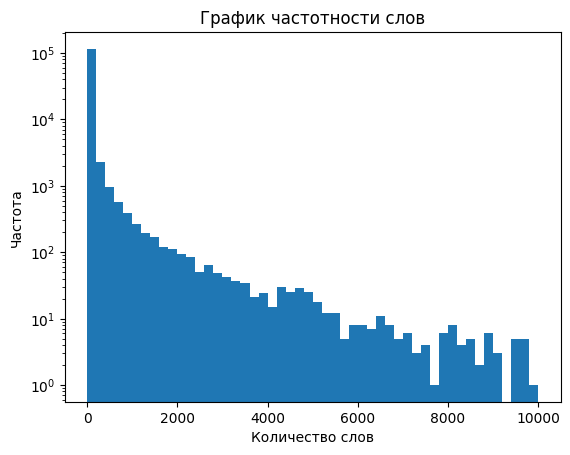

In [50]:
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.title("График частотности слов")
plt.xlabel("Количество слов")
plt.ylabel("Частота")

Отсеиваем слова, которые встретились меньше 20 раз как слова с ошибками, опечатками, или просто те, которые очень редки

In [51]:
tokens = sorted(t for t, c in token_counts.items() if c >= MIN_FREQUENCY_OF_OCCURRENCE)

Добавляем токен паддинга и токен для слова, которого нет в словаре

In [52]:
UNK, PAD = "unk", "pad"
tokens = [UNK, PAD] + tokens

In [53]:
token_to_id = {tok: id for id, tok in enumerate(tokens, 1)}

Конвертируем текст в векторное представление

In [54]:
UNK_IDX, PAD_IDX = map(token_to_id.get, [UNK, PAD])


def text_to_vector(text, max_len):
    matrix = np.full(max_len, np.int32(PAD_IDX))
    text_idx = [token_to_id.get(word, UNK_IDX) for word in text[:max_len]]
    matrix[: len(text_idx)] = text_idx
    return matrix

In [55]:
X = np.array(
    [text_to_vector(text, MAX_SENTENSE_LEN) for text in tqdm(df["text"])],
    dtype=np.int32,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44898/44898 [00:02<00:00, 20833.62it/s]


In [56]:
y = df["label"].to_numpy()

## Обучение сетей

Разделим данные на обучающую и тестовую выборки

In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

Создадим 2 класса моделей для классификации текста: одну сверточную, вторую LSTM

In [76]:
class NewsClassifierCNN(nn.Module):
    def __init__(
        self,
        num_classes: int,
        vocab_size: int,
        embedding_dim=300,
        kernels=(3, 4, 5),
        num_filters=[128, 128, 128],
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d_list = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels=embedding_dim,
                    out_channels=num_filters[i],
                    kernel_size=kernels[i],
                )
                for i in range(len(kernels))
            ]
        )
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(np.sum(num_filters), num_classes)

    def forward(self, x):
        output = self.embedding(x)
        output = output.permute(0, 2, 1)  # bs, emb_dim, len
        x_conv_list = [F.relu(conv1d(output)) for conv1d in self.conv1d_list]

        x_pool_list = [
            F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in x_conv_list
        ]

        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list], dim=1)

        return self.linear(self.dropout(x_fc))

In [115]:
class NewsClassifierLSTM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        num_classes: int,
        embedding_dim: int = 300,
        hidden_size: int = 300,
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=embedding_dim
        )
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embeddings = self.embedding(x)
        output, (hidden, carry) = self.lstm(embeddings)
        return self.linear(hidden[-1])

Создадим класс датасета

In [77]:
class NewsDatasetWrapper(Dataset):
    def __init__(self, data, target=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        else:
            self.target = None

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else -1
        return x, y

    def __len__(self):
        return len(self.data)

Запускаем обучение моделей

In [101]:
batch_size = 256
epochs = 10
num_classes = 2
vocab_size = len(token_to_id)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
train_dataset = NewsDatasetWrapper(X_train, y_train)
test_dataset = NewsDatasetWrapper(X_test, y_test)

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=True),
}

In [116]:
model_cnn = NewsClassifier(vocab_size=vocab_size, num_classes=num_classes).to(device)

model_lstm = NewsClassifierLSTM(vocab_size=vocab_size, num_classes=num_classes).to(
    device
)

In [107]:
def plot_loss_history(loss_history, title):
    plt.title(title)
    plt.grid(True)
    plt.ylabel("Validation loss")
    plt.xlabel("Step")
    plt.plot(loss_history)

In [108]:
def train_model(model, criterion, optimizer, metric, num_epochs=25):
    losses, metrics = [], []
    best_metric = 0.0
    for epoch in tqdm(range(num_epochs)):
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
                if phase == "test":
                    metric.update(outputs.argmax(1), labels)

        epoch_loss = running_loss / len(dataloaders[phase])
        epoch_metric = metric.compute()
        best_metric = epoch_metric if epoch_metric > best_metric else best_metric
        losses.append(epoch_loss)
        metrics.append(float(epoch_metric))
        print(
            f"Epoch: {epoch}, Loss: {epoch_loss:.4f}, Metric: {metric.__class__.__name__}: {epoch_metric:.4f}"
        )
    return losses, metrics, best_metric

In [117]:
for model in (model_lstm, model_cnn):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    model_name = model.__class__.__name__
    print(f"Start train {model_name}...")
    f1_score_fn = F1Score(task="binary", num_classes=num_classes).to(device)
    val_losses, val_metrics, best_metric = train_model(
        model, criterion, optimizer, f1_score_fn, epochs
    )
    print(f"Best f1 metric of {model_name}: {best_metric} ")
    plot_loss_history(val_losses, f"Validation loss history of {model_name}")

Start train NewsClassifierLSTM...


 10%|██████████████████▊                                                                                                                                                                         | 1/10 [00:42<06:20, 42.28s/it]

Epoch: 0, Loss: 0.6714, Metric: BinaryF1Score: 0.6227


 20%|█████████████████████████████████████▌                                                                                                                                                      | 2/10 [01:24<05:39, 42.38s/it]

Epoch: 1, Loss: 0.6091, Metric: BinaryF1Score: 0.6316


 30%|████████████████████████████████████████████████████████▍                                                                                                                                   | 3/10 [02:08<04:59, 42.80s/it]

Epoch: 2, Loss: 0.4387, Metric: BinaryF1Score: 0.6935


 40%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                | 4/10 [02:51<04:19, 43.21s/it]

Epoch: 3, Loss: 0.3589, Metric: BinaryF1Score: 0.7247


 50%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 5/10 [03:36<03:38, 43.68s/it]

Epoch: 4, Loss: 0.2752, Metric: BinaryF1Score: 0.7576


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 6/10 [04:20<02:55, 43.90s/it]

Epoch: 5, Loss: 0.2302, Metric: BinaryF1Score: 0.7839


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 7/10 [05:05<02:12, 44.09s/it]

Epoch: 6, Loss: 0.2051, Metric: BinaryF1Score: 0.8027


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 8/10 [05:49<01:28, 44.22s/it]

Epoch: 7, Loss: 0.1788, Metric: BinaryF1Score: 0.8190


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 9/10 [06:33<00:43, 44.00s/it]

Epoch: 8, Loss: 0.1545, Metric: BinaryF1Score: 0.8325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:16<00:00, 43.67s/it]


Epoch: 9, Loss: 0.2499, Metric: BinaryF1Score: 0.8404
Best f1 metric of NewsClassifierLSTM: 0.8404368162155151 
Start train NewsClassifier...


 10%|██████████████████▊                                                                                                                                                                         | 1/10 [00:32<04:52, 32.55s/it]

Epoch: 0, Loss: 0.2147, Metric: BinaryF1Score: 0.9201


 20%|█████████████████████████████████████▌                                                                                                                                                      | 2/10 [01:05<04:20, 32.56s/it]

Epoch: 1, Loss: 0.1643, Metric: BinaryF1Score: 0.9288


 30%|████████████████████████████████████████████████████████▍                                                                                                                                   | 3/10 [01:37<03:47, 32.54s/it]

Epoch: 2, Loss: 0.1443, Metric: BinaryF1Score: 0.9336


 30%|████████████████████████████████████████████████████████▍                                                                                                                                   | 3/10 [02:05<04:53, 41.93s/it]


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f069e961000> (for post_execute):


KeyboardInterrupt: 

Вывод: по результатам обучения лучше себя показала модель, основанная на свертках